In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
!pip install kneed
from kneed import KneeLocator

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
# We build a graph from the payment data. We created a list of directed edges with weights.
# We then converted nodes to indices and build adjacency list.

def load_and_create_graph(file_path):
    df = pd.read_excel(file_path)
    sender_list = df['Sender'].astype(int).tolist()
    receiver_list = df['Receiver'].astype(int).tolist()
    amount_list = df['Amount'].astype(int).tolist()

    nodes = list(set(sender_list + receiver_list))
    node_to_idx = {node: idx for idx, node in enumerate(nodes)}
    n_nodes = len(nodes)

    directed_edges = defaultdict(list)
    for sender, receiver, amount in zip(sender_list, receiver_list, amount_list):
        found = False
        for i, (recv, amt) in enumerate(directed_edges[sender]):
            if recv == receiver:
                directed_edges[sender][i] = (recv, amt + amount)
                found = True
                break
        if not found:
            directed_edges[sender].append((receiver, amount))

    adj_list = defaultdict(list)
    for sender in directed_edges:
        for receiver, amount in directed_edges[sender]:
            adj_list[node_to_idx[sender]].append((node_to_idx[receiver], amount))

    return nodes, node_to_idx, adj_list, n_nodes

In [41]:
# This function generates walks using Node2Vec Strategy. If it's the first step, pick random neighbour.
# If not, we use transition probabilities (based on p and q). We use alias sampling to pick next node.

def generate_node2vec_walks(adj_list, num_walks, walk_length, p, q, n_nodes):
    walks = []

    for _ in range(num_walks):
        nodes = list(range(n_nodes))
        random.shuffle(nodes)

        for start_node in nodes:
            walk = [start_node]

            while len(walk) < walk_length:
                cur = walk[-1]
                cur_neighbors = [n for n, _ in adj_list[cur]]

                if not cur_neighbors:
                    break

                if len(walk) == 1:
                    probs = np.ones(len(cur_neighbors)) / len(cur_neighbors)
                    q_vals = np.zeros(len(probs))
                    J = np.zeros(len(probs), dtype=np.int32)

                    smaller, larger = [], []
                    for i, prob in enumerate(probs):
                        q_vals[i] = len(probs) * prob
                        if q_vals[i] < 1.0:
                            smaller.append(i)
                        else:
                            larger.append(i)

                    while smaller and larger:
                        small = smaller.pop()
                        large = larger.pop()
                        J[small] = large
                        q_vals[large] = q_vals[large] + q_vals[small] - 1.0
                        if q_vals[large] < 1.0:
                            smaller.append(large)
                        else:
                            larger.append(large)

                    kk = int(np.floor(np.random.rand() * len(J)))
                    next_idx = kk if np.random.rand() < q_vals[kk] else J[kk]
                    walk.append(cur_neighbors[next_idx])

                else:
                    prev = walk[-2]
                    dst_neighbors = [n for n, _ in adj_list[cur]]

                    unnormalized_probs = []
                    for dst_neighbor in dst_neighbors:
                        if dst_neighbor == prev:
                            unnormalized_probs.append(1.0 / p)
                        elif any(n == dst_neighbor for n, _ in adj_list[prev]):
                            unnormalized_probs.append(1.0)
                        else:
                            unnormalized_probs.append(1.0 / q)

                    probs = np.array(unnormalized_probs)
                    probs /= probs.sum()

                    q_vals = np.zeros(len(probs))
                    J = np.zeros(len(probs), dtype=np.int32)

                    smaller, larger = [], []
                    for i, prob in enumerate(probs):
                        q_vals[i] = len(probs) * prob
                        if q_vals[i] < 1.0:
                            smaller.append(i)
                        else:
                            larger.append(i)

                    while smaller and larger:
                        small = smaller.pop()
                        large = larger.pop()
                        J[small] = large
                        q_vals[large] = q_vals[large] + q_vals[small] - 1.0
                        if q_vals[large] < 1.0:
                            smaller.append(large)
                        else:
                            larger.append(large)

                    kk = int(np.floor(np.random.rand() * len(J)))
                    next_idx = kk if np.random.rand() < q_vals[kk] else J[kk]
                    walk.append(dst_neighbors[next_idx])

            walks.append(walk)

    return walks


In [42]:
# We define Skip-Gram model with negative sampling.Compute loss using positive and negative samples.

class SkipGramNegSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramNegSampling, self).__init__()
        self.input_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, center, context, negative_samples):
        center_embeds = self.input_embeddings(center)
        context_embeds = self.output_embeddings(context)
        negative_embeds = self.output_embeddings(negative_samples)

        # Positive score
        pos_score = torch.sum(center_embeds * context_embeds, dim=1)
        pos_loss = torch.log(torch.sigmoid(pos_score) + 1e-10)

        # Negative score
        neg_score = torch.bmm(negative_embeds, center_embeds.unsqueeze(2)).squeeze()
        neg_loss = torch.sum(torch.log(torch.sigmoid(-neg_score) + 1e-10), dim=1)

        loss = -torch.mean(pos_loss + neg_loss)
        return loss

    def get_embeddings(self):
        return self.input_embeddings.weight.detach().cpu().numpy()


In [43]:
# Train the skip-gram model with negative sampling

def train_skipgram_negative_sampling(pairs, n_nodes, embedding_dim, epochs, learning_rate, batch_size, num_negatives, device):
    model = SkipGramNegSampling(n_nodes, embedding_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    dataset = SkipGramNegDataset(pairs, n_nodes, num_negatives)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for center, context, negatives in dataloader:
            center = center.to(device)
            context = context.to(device)
            negatives = negatives.to(device)

            optimizer.zero_grad()
            loss = model(center, context, negatives)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

    embeddings = model.get_embeddings()
    return embeddings


In [58]:
# Use elbow method to find the best number of clusters
# Use PCA to visualize embeddings in 2D

def cluster_and_visualize(embeddings, nodes, max_k=10):
    distortions = []
    K_range = range(1, max_k + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        distortions.append(kmeans.inertia_)

    # Use KneeLocator to find optimal k
    knee = KneeLocator(K_range, distortions, curve='convex', direction='decreasing')
    optimal_k = knee.elbow if knee.elbow else 5

    # Plot elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(K_range, distortions, 'bo-', label='Distortion')
    if knee.elbow:
        plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Distortion (Inertia)')
    plt.title('Elbow Method with KneeLocator')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Final KMeans clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    labels = kmeans.fit_predict(embeddings)

    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    cmap = plt.get_cmap('tab10')

    for cluster_id in range(optimal_k):
        indices = np.where(labels == cluster_id)
        plt.scatter(embeddings_2d[indices, 0],
                    embeddings_2d[indices, 1],
                    s=100,
                    color=cmap(cluster_id),
                    label=f"Cluster {cluster_id}")

    plt.title("Node2Vec Embeddings Visualized with PCA")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()


    cluster_dict = defaultdict(list)
    for idx, label in enumerate(labels):
        original_node = nodes[idx]
        cluster_dict[label].append(original_node)

    for cluster_id in sorted(cluster_dict):
        print(f"\nCluster {cluster_id}:")
        print(cluster_dict[cluster_id])

    return labels

In [45]:
# Generate (center, context) word pairs from walks.

def generate_skipgram_pairs(walks, context_size):
    pairs = []
    for walk in walks:
        for i, center in enumerate(walk):
            for j in range(max(0, i - context_size), min(len(walk), i + context_size + 1)):
                if i != j:
                    pairs.append((center, walk[j]))
    return pairs

# Custom dataset to sample negative examples

class SkipGramNegDataset(torch.utils.data.Dataset):
    def __init__(self, pairs, vocab_size, num_negatives):
        self.pairs = pairs
        self.vocab_size = vocab_size
        self.num_negatives = num_negatives

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        center, context = self.pairs[idx]
        negatives = []
        while len(negatives) < self.num_negatives:
            neg = random.randint(0, self.vocab_size - 1)
            if neg != context:
                negatives.append(neg)
        return torch.tensor(center), torch.tensor(context), torch.tensor(negatives)

In [50]:
# Parameters
file_path = "Payments.xlsx"
num_walks = 20
walk_length = 100
p = 0.5
q = 2.0
embedding_dim = 64
context_size = 5
epochs = 10
learning_rate = 0.01
n_clusters = 5
num_negatives=5

In [47]:
nodes, node_to_idx, adj_list, n_nodes = load_and_create_graph(file_path)

In [51]:
walks = generate_node2vec_walks(adj_list, num_walks, walk_length, p, q, n_nodes)

In [52]:
pairs = generate_skipgram_pairs(walks, context_size)
embeddings = train_skipgram_negative_sampling(pairs, n_nodes, embedding_dim, epochs, learning_rate, num_negatives=5, batch_size=128, device=device)


Epoch 1, Loss: 0.6495
Epoch 2, Loss: 0.5141
Epoch 3, Loss: 0.5127
Epoch 4, Loss: 0.5116
Epoch 5, Loss: 0.5119
Epoch 6, Loss: 0.5121
Epoch 7, Loss: 0.5114
Epoch 8, Loss: 0.5121
Epoch 9, Loss: 0.5125
Epoch 10, Loss: 0.5116


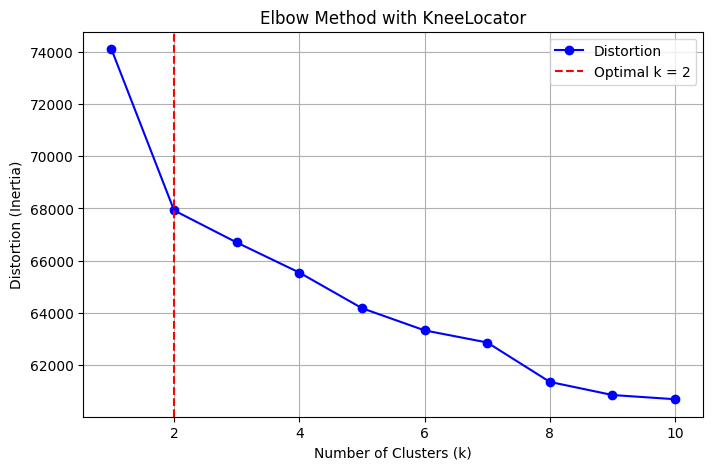

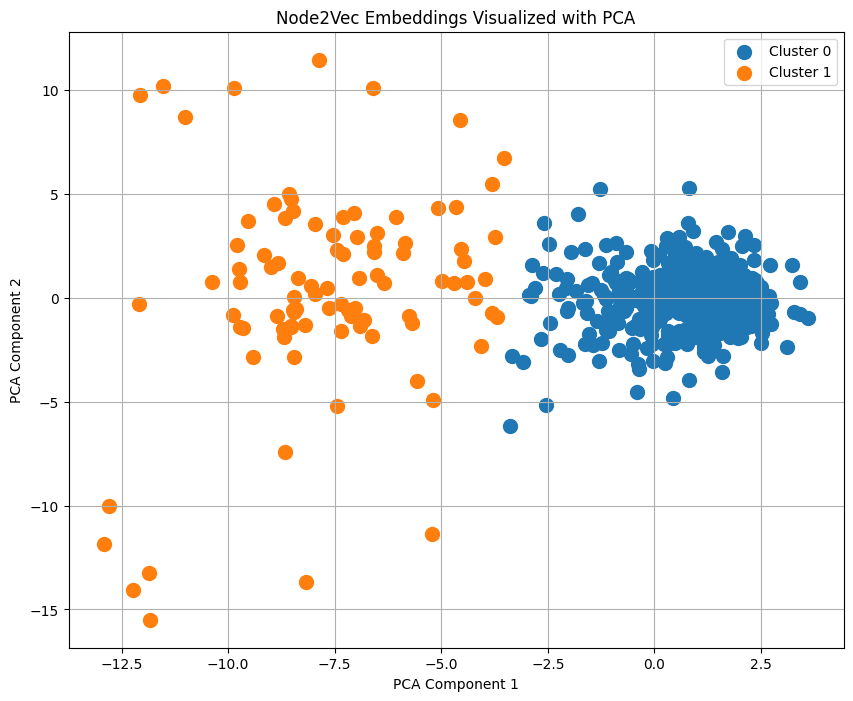


Cluster 0:
[2050, 2053, 2054, 2057, 2060, 2061, 2062, 2066, 2071, 2072, 2073, 2075, 2076, 2080, 2081, 2084, 2085, 2088, 2089, 2090, 2097, 2100, 2101, 2104, 2107, 2108, 2109, 2111, 2124, 2126, 2127, 2136, 2137, 2142, 2145, 2146, 2150, 2151, 2152, 2158, 2162, 2164, 2166, 2168, 2169, 2170, 2171, 2172, 2174, 2177, 2182, 2184, 2188, 2189, 2190, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1046, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1096, 1097, 1098, 1099, 1100, 1101, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 111

In [59]:
labels = cluster_and_visualize(embeddings, nodes)